### Import libraries

In [2]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Custom functions

In [3]:
'''
1. Data Augmentation method   
'''
def speedNpitch(data):
    """
    Speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

'''
2. Extracting the MFCC feature as an image (Matrix format).  
'''
def prepare_data(df, n, aug, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        # Augmentation? 
        if aug == 1:
            data = speedNpitch(data)
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X


'''
3. Confusion matrix plot 
'''        
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    '''Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
'''
# 4. Create the 2D CNN model 
'''
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 14
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = tf.optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


### Load the Data

In [4]:
ref = pd.read_csv("C:/Users/aksha/Downloads/College Project/Code/SpeechEmotionRecognitionwithCNN/Data_path.csv")
ref.head()

,labels,source,path
0,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...
1,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...
2,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...
3,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...
4,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...


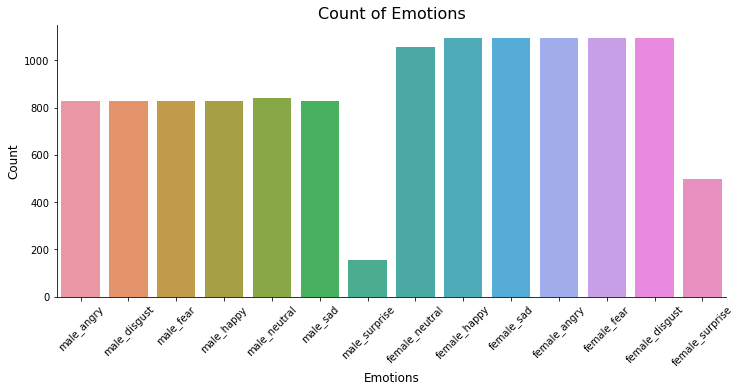

In [6]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(ref.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# 2D CNN with MFCC without augmentation

### Data preparation and processing

In [4]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(ref, n = n_mfcc, aug = 0, mfcc = 1)

100%|████████████████████████████████████████████████████████████████████████████| 12162/12162 [05:40<00:00, 35.71it/s]


### Splitting the Dataset into Training and Test for 2D CNN with MFCC without augmentation

In [9]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

### Normalization for 2D CNN with MFCC without augmentation

In [11]:
# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

### Description of 2D CNN-Model with MFCC without augmentation

In [12]:
# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)

Epoch 1/20
571/571 - 112s - loss: 2.2691 - acc: 0.2342 - val_loss: 1.7328 - val_acc: 0.4199
Epoch 2/20
571/571 - 110s - loss: 1.7247 - acc: 0.4007 - val_loss: 1.5353 - val_acc: 0.4505
Epoch 3/20
571/571 - 107s - loss: 1.4801 - acc: 0.4794 - val_loss: 1.3553 - val_acc: 0.5107
Epoch 4/20
571/571 - 107s - loss: 1.3540 - acc: 0.5120 - val_loss: 1.2958 - val_acc: 0.5314
Epoch 5/20
571/571 - 107s - loss: 1.2839 - acc: 0.5400 - val_loss: 1.4051 - val_acc: 0.4860
Epoch 6/20
571/571 - 107s - loss: 1.2258 - acc: 0.5615 - val_loss: 1.1676 - val_acc: 0.5663
Epoch 7/20
571/571 - 109s - loss: 1.1747 - acc: 0.5750 - val_loss: 1.1962 - val_acc: 0.5725
Epoch 8/20
571/571 - 108s - loss: 1.1428 - acc: 0.5882 - val_loss: 1.0904 - val_acc: 0.5876
Epoch 9/20
571/571 - 108s - loss: 1.1084 - acc: 0.6003 - val_loss: 1.0520 - val_acc: 0.6146
Epoch 10/20
571/571 - 108s - loss: 1.0835 - acc: 0.6084 - val_loss: 1.0027 - val_acc: 0.6264
Epoch 11/20
571/571 - 109s - loss: 1.0486 - acc: 0.6252 - val_loss: 1.0520 - va

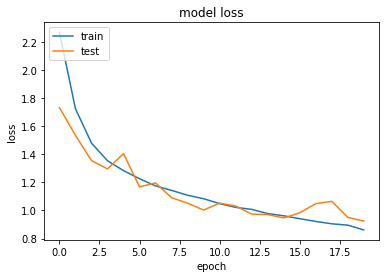

In [13]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model serialisation for 2D CNN with MFCC without augmentation

In [35]:
# Save model and weights
model_name = 'Emotion_Model_2D_CNN_MFCC.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json_2D_CNN_MFCC.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at C:\Users\aksha\Downloads\College Project\Code\SER\saved_models\Emotion_Model_2D_CNN_MFCC.h5 


### Model validation for 2D CNN with MFCC without augmentation

In [41]:
# loading json and model architecture 
json_file = open('model_json_2D_CNN_MFCC.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_2D_CNN_MFCC.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


ValueError: in user code:

    C:\Users\aksha\anaconda3\lib\site-packages\keras\engine\training.py:1330 test_function  *
        return step_function(self, iterator)
    C:\Users\aksha\anaconda3\lib\site-packages\keras\engine\training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\aksha\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\aksha\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\aksha\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\aksha\anaconda3\lib\site-packages\keras\engine\training.py:1313 run_step  **
        outputs = model.test_step(data)
    C:\Users\aksha\anaconda3\lib\site-packages\keras\engine\training.py:1267 test_step
        y_pred = self(x, training=False)
    C:\Users\aksha\anaconda3\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\aksha\anaconda3\lib\site-packages\keras\engine\input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 30, 216, 1), found shape=(None, 60, 216, 1)


In [37]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

191/191 [==============================] - 5s 27ms/step


array([ 4,  3,  8, ...,  9, 12,  0], dtype=int64)

In [38]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,male_sad
171,female_neutral,female_neutral
172,male_angry,male_angry
173,female_disgust,female_disgust
174,male_angry,male_angry
175,female_fear,female_happy
176,male_neutral,male_neutral
177,female_fear,female_fear
178,female_happy,female_neutral
179,female_neutral,female_neutral


In [39]:
# Write out the predictions to disk
finaldf.to_csv('Predictions_2D_CNN.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,300
female_disgust,209
female_fear,270
female_happy,287
female_neutral,295
female_sad,297
female_surprise,128
male_angry,180
male_disgust,190


### Emotion vs Gender Accuracy for 2D CNN with MFCC without augmentation

In [40]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

### Emotion by gender accuracy for 2D CNN with MFCC without augmentation

0.658993752055245


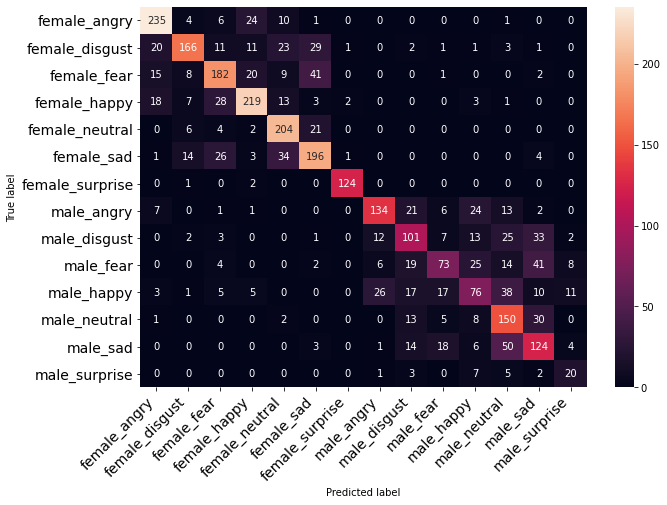

In [41]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions_2D_CNN.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [42]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.78      0.84      0.81       281
 female_disgust       0.79      0.62      0.69       269
    female_fear       0.67      0.65      0.66       278
   female_happy       0.76      0.74      0.75       294
 female_neutral       0.69      0.86      0.77       237
     female_sad       0.66      0.70      0.68       279
female_surprise       0.97      0.98      0.97       127
     male_angry       0.74      0.64      0.69       209
   male_disgust       0.53      0.51      0.52       199
      male_fear       0.57      0.38      0.46       192
     male_happy       0.47      0.36      0.41       209
   male_neutral       0.50      0.72      0.59       209
       male_sad       0.50      0.56      0.53       220
  male_surprise       0.44      0.53      0.48        38

       accuracy                           0.66      3041
      macro avg       0.65      0.65      0.64      3041
   weighted avg       0.66   

### Gender Accuracy Result for 2D CNN with MFCC without augmentation

0.9799408089444261


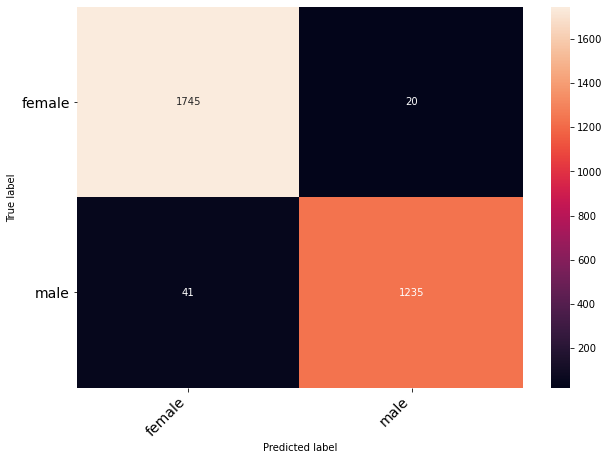

In [43]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [44]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.98      0.99      0.98      1765
        male       0.98      0.97      0.98      1276

    accuracy                           0.98      3041
   macro avg       0.98      0.98      0.98      3041
weighted avg       0.98      0.98      0.98      3041



### Emotion Accuracy for 2D CNN with MFCC without augmentation

0.6698454455771128


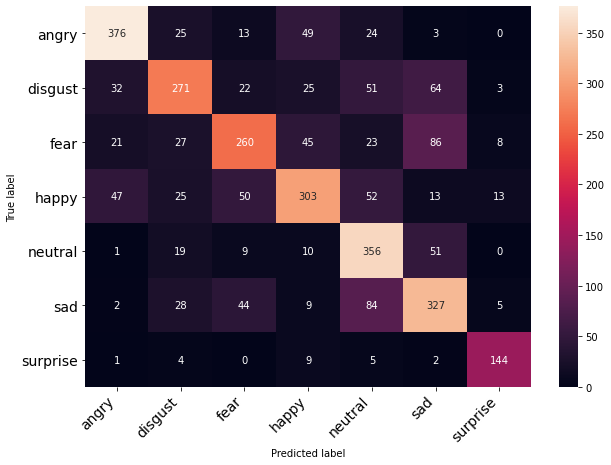

In [45]:
modidf = pd.read_csv("Predictions_2D_CNN.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [40]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.61      0.60      0.60      1465
     disgust       0.52      0.47      0.49      1413
        fear       0.44      0.47      0.46      1393
       happy       0.41      0.57      0.48      1467
     neutral       0.57      0.52      0.54      1429
         sad       0.60      0.48      0.53      1473
    surprise       0.79      0.67      0.72       482

    accuracy                           0.53      9122
   macro avg       0.56      0.54      0.55      9122
weighted avg       0.54      0.53      0.53      9122



# 2D CNN with MFCC and Augmentation

### Data preparation and processing for 2D CNN with MFCC and Augmentation

In [7]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc_aug = prepare_data(ref, n = n_mfcc, aug = 1, mfcc = 1)

100%|████████████████████████████████████████████████████████████████████████████| 12162/12162 [06:05<00:00, 33.24it/s]


### Splitting the Dataset into Training and Test for 2D CNN with MFCC and Augmentation

In [1]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc_aug
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

NameError: name 'train_test_split' is not defined

### Modelling for 2D CNN with MFCC and Augmentation

In [9]:
# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)

Epoch 1/20
571/571 - 121s - loss: 2.2188 - acc: 0.2508 - val_loss: 1.9163 - val_acc: 0.3505
Epoch 2/20
571/571 - 117s - loss: 1.7607 - acc: 0.3836 - val_loss: 1.6155 - val_acc: 0.4301
Epoch 3/20
571/571 - 121s - loss: 1.5714 - acc: 0.4514 - val_loss: 1.3872 - val_acc: 0.4952
Epoch 4/20
571/571 - 125s - loss: 1.4582 - acc: 0.4855 - val_loss: 1.3205 - val_acc: 0.5225
Epoch 5/20
571/571 - 123s - loss: 1.3967 - acc: 0.5063 - val_loss: 1.4762 - val_acc: 0.4716
Epoch 6/20
571/571 - 125s - loss: 1.3220 - acc: 0.5285 - val_loss: 1.1708 - val_acc: 0.5682
Epoch 7/20
571/571 - 119s - loss: 1.2859 - acc: 0.5422 - val_loss: 1.2559 - val_acc: 0.5396
Epoch 8/20
571/571 - 121s - loss: 1.2382 - acc: 0.5575 - val_loss: 1.1798 - val_acc: 0.5439
Epoch 9/20
571/571 - 126s - loss: 1.1937 - acc: 0.5720 - val_loss: 1.1825 - val_acc: 0.5692
Epoch 10/20
571/571 - 122s - loss: 1.1720 - acc: 0.5827 - val_loss: 1.1182 - val_acc: 0.5791
Epoch 11/20
571/571 - 120s - loss: 1.1508 - acc: 0.5882 - val_loss: 1.0353 - va

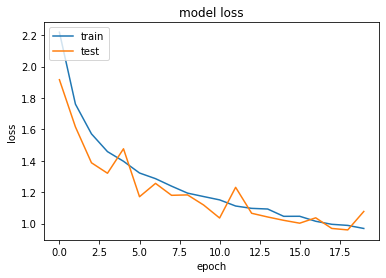

In [11]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model serialisation for 2D CNN with MFCC and Augmentation

In [14]:
# Save model and weights
model_name = 'Emotion_Model_2D_CNN_MFCC_Augmentation.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json_2D_CNN_MFCC_Augmentation.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at C:\Users\aksha\Downloads\College Project\Code\SER\saved_models\Emotion_Model_2D_CNN_MFCC_Augmentation.h5 


### Model validationfor 2D CNN with MFCC and Augmentation

In [15]:
# loading json and model architecture 
json_file = open('model_json_2D_CNN_MFCC_Augmentation.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_2D_CNN_MFCC_Augmentation.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 61.56%


In [16]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

191/191 [==============================] - 5s 25ms/step


array([ 4,  3,  8, ...,  0, 12,  4], dtype=int64)

In [17]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,male_sad
171,female_neutral,female_neutral
172,male_angry,male_angry
173,female_disgust,female_disgust
174,male_angry,male_angry
175,female_fear,female_neutral
176,male_neutral,male_neutral
177,female_fear,female_fear
178,female_happy,female_happy
179,female_neutral,female_neutral


In [18]:
# Write out the predictions to disk
finaldf.to_csv('Predictions_2D_CNN_MFCC_Augmentation.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,240
female_disgust,279
female_fear,207
female_happy,397
female_neutral,382
female_sad,251
female_surprise,132
male_angry,127
male_disgust,151


### Emotion vs Gender Accuracy for 2D CNN with MFCC and Augmentation

In [19]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

### Emotion by gender accuracy

0.6155869779677737


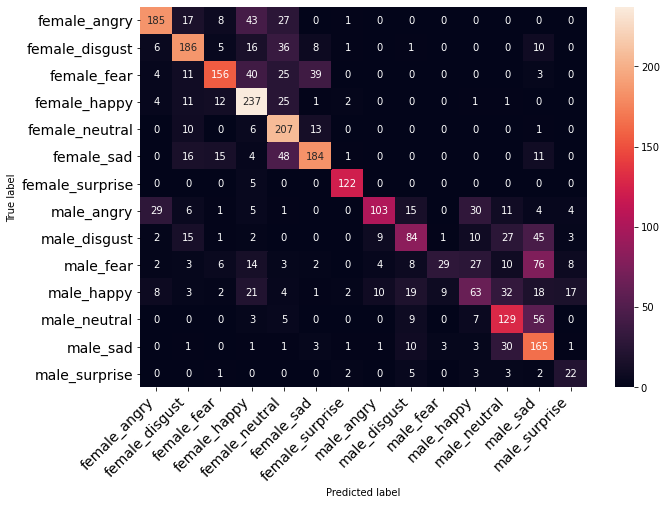

In [20]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions_2D_CNN_MFCC_Augmentation.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [21]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.77      0.66      0.71       281
 female_disgust       0.67      0.69      0.68       269
    female_fear       0.75      0.56      0.64       278
   female_happy       0.60      0.81      0.69       294
 female_neutral       0.54      0.87      0.67       237
     female_sad       0.73      0.66      0.69       279
female_surprise       0.92      0.96      0.94       127
     male_angry       0.81      0.49      0.61       209
   male_disgust       0.56      0.42      0.48       199
      male_fear       0.69      0.15      0.25       192
     male_happy       0.44      0.30      0.36       209
   male_neutral       0.53      0.62      0.57       209
       male_sad       0.42      0.75      0.54       220
  male_surprise       0.40      0.58      0.47        38

       accuracy                           0.62      3041
      macro avg       0.63      0.61      0.59      3041
   weighted avg       0.64   

### Gender Accuracy Result

0.941137783623808


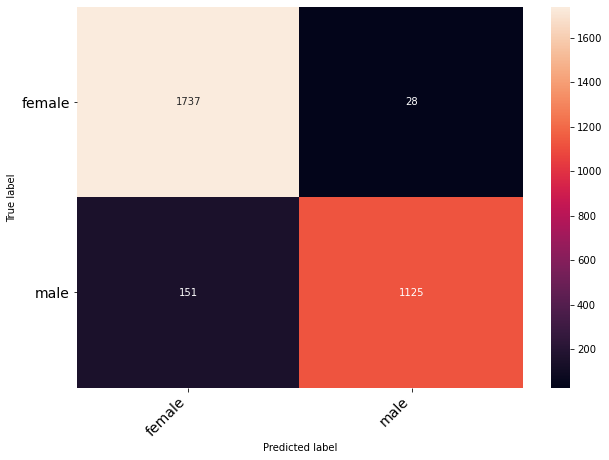

In [22]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [23]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.92      0.98      0.95      1765
        male       0.98      0.88      0.93      1276

    accuracy                           0.94      3041
   macro avg       0.95      0.93      0.94      3041
weighted avg       0.94      0.94      0.94      3041



### Emotion Accuracy

0.526200394650296


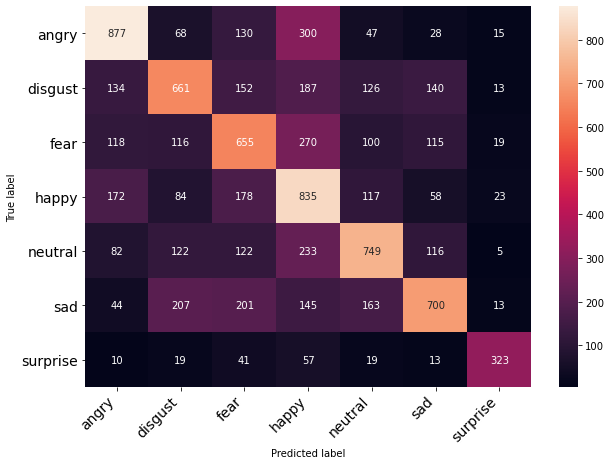

In [24]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [25]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.61      0.60      0.60      1465
     disgust       0.52      0.47      0.49      1413
        fear       0.44      0.47      0.46      1393
       happy       0.41      0.57      0.48      1467
     neutral       0.57      0.52      0.54      1429
         sad       0.60      0.48      0.53      1473
    surprise       0.79      0.67      0.72       482

    accuracy                           0.53      9122
   macro avg       0.56      0.54      0.55      9122
weighted avg       0.54      0.53      0.53      9122



# 2D CNN Log-melspectogram without augmentation

In [6]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
specgram = prepare_data(ref, n = n_melspec, aug = 0, mfcc = 0)

100%|████████████████████████████████████████████████████████████████████████████| 12162/12162 [05:18<00:00, 38.19it/s]


### Splitting the Dataset into Training and Test for 2D CNN Log-melspectogram without augmentation

In [8]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(specgram
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

### Normalization 2D CNN Log-melspectogram without augmentation

In [9]:
# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


### Modelling for 2D CNN Log-melspectogram without augmentation

In [10]:
# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)

Epoch 1/20
571/571 - 230s - loss: 2.3412 - acc: 0.2079 - val_loss: 1.9909 - val_acc: 0.3111
Epoch 2/20
571/571 - 234s - loss: 1.9126 - acc: 0.3323 - val_loss: 1.8303 - val_acc: 0.3535
Epoch 3/20
571/571 - 238s - loss: 1.6952 - acc: 0.3954 - val_loss: 1.5686 - val_acc: 0.4581
Epoch 4/20
571/571 - 238s - loss: 1.5528 - acc: 0.4533 - val_loss: 1.4449 - val_acc: 0.4732
Epoch 5/20
571/571 - 228s - loss: 1.4530 - acc: 0.4809 - val_loss: 1.4713 - val_acc: 0.4630
Epoch 6/20
571/571 - 238s - loss: 1.3709 - acc: 0.5127 - val_loss: 1.3311 - val_acc: 0.5123
Epoch 7/20
571/571 - 233s - loss: 1.3155 - acc: 0.5254 - val_loss: 1.1309 - val_acc: 0.5873
Epoch 8/20
571/571 - 234s - loss: 1.2714 - acc: 0.5480 - val_loss: 1.1412 - val_acc: 0.5801
Epoch 9/20
571/571 - 229s - loss: 1.2380 - acc: 0.5543 - val_loss: 1.0803 - val_acc: 0.6077
Epoch 10/20
571/571 - 237s - loss: 1.1719 - acc: 0.5707 - val_loss: 1.0614 - val_acc: 0.6215
Epoch 11/20
571/571 - 228s - loss: 1.1623 - acc: 0.5843 - val_loss: 1.0300 - va

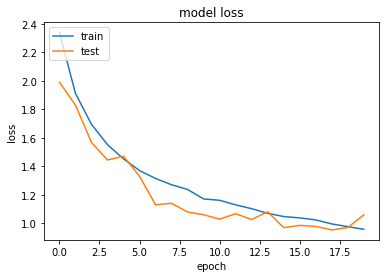

In [11]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model serialisation for 2D CNN Log-melspectogram without augmentation

In [12]:
# Save model and weights
model_name = 'Emotion_Model_2D_CNN_Log_melspectogram.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json_2D_CNN_Log_melspectogram.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at C:\Users\aksha\Downloads\College Project\Code\SER\saved_models\Emotion_Model_2D_CNN_Log_melspectogram.h5 


### Model validationfor for 2D CNN Log-melspectogram without augmentation

In [13]:
# loading json and model architecture 
json_file = open('model_json_2D_CNN_Log_melspectogram.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_2D_CNN_Log_melspectogram.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 61.43%


In [14]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

191/191 [==============================] - 11s 58ms/step


array([ 4,  3,  8, ...,  7, 11,  0], dtype=int64)

In [15]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,male_sad
171,female_neutral,female_neutral
172,male_angry,male_angry
173,female_disgust,female_disgust
174,male_angry,male_angry
175,female_fear,female_fear
176,male_neutral,male_neutral
177,female_fear,female_fear
178,female_happy,female_neutral
179,female_neutral,female_neutral


In [16]:
# Write out the predictions to disk
finaldf.to_csv('Predictions_2D_CNN_Log_melspectogram.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,431
female_disgust,252
female_fear,234
female_happy,212
female_neutral,242
female_sad,238
female_surprise,143
male_angry,416
male_disgust,234


### Emotion vs Gender Accuracy for 2D CNN Log-melspectogram without augmentation

In [17]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

### Emotion by gender accuracy of 2D CNN Log-melspectogram without augmentation

0.6142716211772443


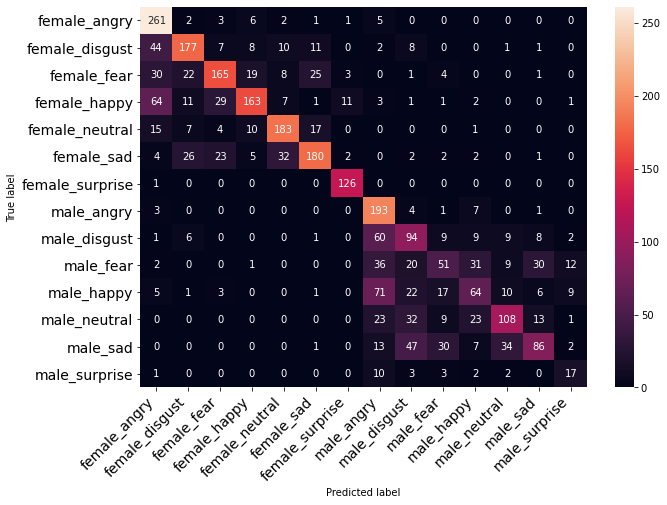

In [18]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions_2D_CNN_Log_melspectogram.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [19]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.61      0.93      0.73       281
 female_disgust       0.70      0.66      0.68       269
    female_fear       0.71      0.59      0.64       278
   female_happy       0.77      0.55      0.64       294
 female_neutral       0.76      0.77      0.76       237
     female_sad       0.76      0.65      0.70       279
female_surprise       0.88      0.99      0.93       127
     male_angry       0.46      0.92      0.62       209
   male_disgust       0.40      0.47      0.43       199
      male_fear       0.40      0.27      0.32       192
     male_happy       0.43      0.31      0.36       209
   male_neutral       0.62      0.52      0.57       209
       male_sad       0.59      0.39      0.47       220
  male_surprise       0.39      0.45      0.41        38

       accuracy                           0.61      3041
      macro avg       0.61      0.60      0.59      3041
   weighted avg       0.63   

### Gender Accuracy Result of 2D CNN Log-melspectogram without augmentation

0.9786254521538967


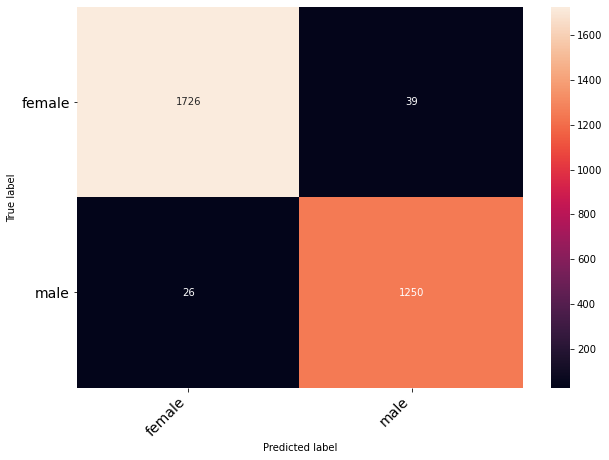

In [20]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [21]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.99      0.98      0.98      1765
        male       0.97      0.98      0.97      1276

    accuracy                           0.98      3041
   macro avg       0.98      0.98      0.98      3041
weighted avg       0.98      0.98      0.98      3041



### Emotion Accuracy of 2D CNN Log-melspectogram without augmentation

0.526200394650296


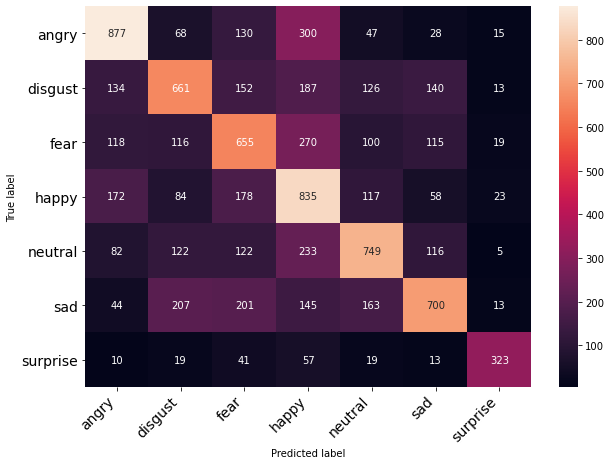

In [22]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [23]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.61      0.60      0.60      1465
     disgust       0.52      0.47      0.49      1413
        fear       0.44      0.47      0.46      1393
       happy       0.41      0.57      0.48      1467
     neutral       0.57      0.52      0.54      1429
         sad       0.60      0.48      0.53      1473
    surprise       0.79      0.67      0.72       482

    accuracy                           0.53      9122
   macro avg       0.56      0.54      0.55      9122
weighted avg       0.54      0.53      0.53      9122



# 2D CNN Log-melspectogram with Data augmentation

In [24]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
aug_specgram = prepare_data(ref,  n = n_melspec, aug = 1, mfcc = 0)

100%|████████████████████████████████████████████████████████████████████████████| 12162/12162 [06:32<00:00, 31.02it/s]


### Splitting the Dataset into Training and Test for 2D CNN Log-melspectogram with Data augmentation

In [25]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(aug_specgram, ref.labels, test_size=0.25, shuffle=True, random_state=42)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

### Normalization for 2D CNN Log-melspectogram with Data augmentation

In [26]:
# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

### Modelling for 2D CNN Log-melspectogram with Data augmentation

In [27]:
# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)

Epoch 1/20
571/571 - 227s - loss: 2.2466 - acc: 0.2310 - val_loss: 1.9797 - val_acc: 0.2983
Epoch 2/20
571/571 - 228s - loss: 1.8715 - acc: 0.3425 - val_loss: 1.6777 - val_acc: 0.4061
Epoch 3/20
571/571 - 232s - loss: 1.6773 - acc: 0.4132 - val_loss: 1.6206 - val_acc: 0.4163
Epoch 4/20
571/571 - 241s - loss: 1.5504 - acc: 0.4564 - val_loss: 1.4558 - val_acc: 0.4841
Epoch 5/20
571/571 - 227s - loss: 1.4712 - acc: 0.4822 - val_loss: 1.3155 - val_acc: 0.5344
Epoch 6/20
571/571 - 230s - loss: 1.4095 - acc: 0.4999 - val_loss: 1.2802 - val_acc: 0.5340
Epoch 7/20
571/571 - 218s - loss: 1.3485 - acc: 0.5227 - val_loss: 1.2660 - val_acc: 0.5416
Epoch 8/20
571/571 - 232s - loss: 1.3097 - acc: 0.5331 - val_loss: 1.2342 - val_acc: 0.5544
Epoch 9/20
571/571 - 232s - loss: 1.2712 - acc: 0.5514 - val_loss: 1.1340 - val_acc: 0.5916
Epoch 10/20
571/571 - 232s - loss: 1.2382 - acc: 0.5586 - val_loss: 1.1230 - val_acc: 0.5968
Epoch 11/20
571/571 - 231s - loss: 1.2125 - acc: 0.5750 - val_loss: 1.1646 - va

### Model serialisation for 2D CNN Log-melspectogram with Data augmentation

In [28]:
# Save model and weights
model_name = 'Emotion_Model_2D_CNN_Log_melspectogram_Data_augmentation.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json_2D_CNN_Log_melspectogram_Data_augmentation.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at C:\Users\aksha\Downloads\College Project\Code\SER\saved_models\Emotion_Model_2D_CNN_Log_melspectogram_Data_augmentation.h5 


### Model validationfor for 2D CNN Log-melspectogram with Data augmentation

In [29]:
# loading json and model architecture 
json_file = open('model_json_2D_CNN_Log_melspectogram_Data_augmentation.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_2D_CNN_Log_melspectogram_Data_augmentation.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 62.08%


In [30]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

191/191 [==============================] - 10s 52ms/step


array([ 4,  3,  8, ...,  0, 11,  1], dtype=int64)

In [31]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,male_sad
171,female_neutral,female_neutral
172,male_angry,male_fear
173,female_disgust,female_disgust
174,male_angry,male_fear
175,female_fear,female_happy
176,male_neutral,male_neutral
177,female_fear,female_fear
178,female_happy,female_happy
179,female_neutral,female_neutral


In [32]:
# Write out the predictions to disk
finaldf.to_csv('Predictions_2D_CNN_Log_melspectogram_Data_augmentation.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,235
female_disgust,220
female_fear,329
female_happy,350
female_neutral,268
female_sad,193
female_surprise,145
male_angry,181
male_disgust,245


### Emotion vs Gender Accuracy for 2D CNN Log-melspectogram with Data augmentation

In [33]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

### Emotion by gender accuracy of 2D CNN Log-melspectogram with Data augmentation

0.6208484051298915


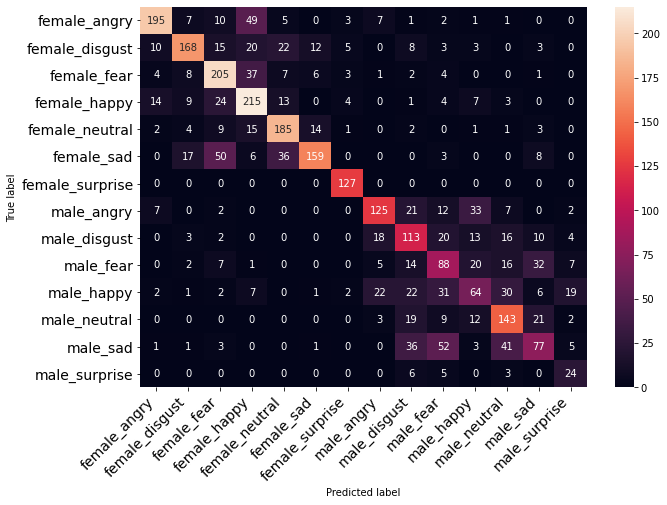

In [34]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions_2D_CNN_Log_melspectogram_Data_augmentation.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [35]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.83      0.69      0.76       281
 female_disgust       0.76      0.62      0.69       269
    female_fear       0.62      0.74      0.68       278
   female_happy       0.61      0.73      0.67       294
 female_neutral       0.69      0.78      0.73       237
     female_sad       0.82      0.57      0.67       279
female_surprise       0.88      1.00      0.93       127
     male_angry       0.69      0.60      0.64       209
   male_disgust       0.46      0.57      0.51       199
      male_fear       0.38      0.46      0.41       192
     male_happy       0.41      0.31      0.35       209
   male_neutral       0.55      0.68      0.61       209
       male_sad       0.48      0.35      0.40       220
  male_surprise       0.38      0.63      0.48        38

       accuracy                           0.62      3041
      macro avg       0.61      0.62      0.61      3041
   weighted avg       0.63   

### Gender Accuracy Result of 2D CNN Log-melspectogram with Data augmentation

0.9621834922722788


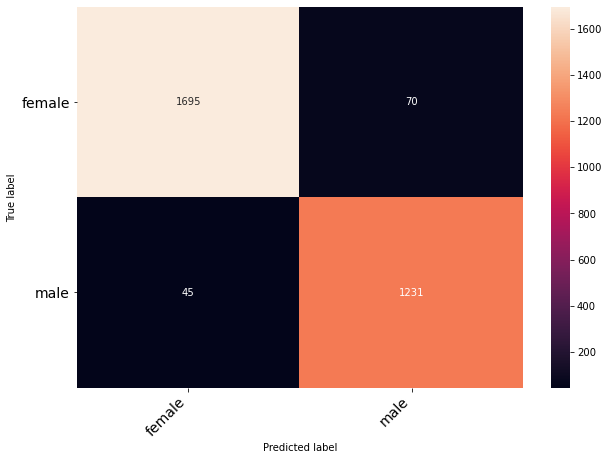

In [36]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [37]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.97      0.96      0.97      1765
        male       0.95      0.96      0.96      1276

    accuracy                           0.96      3041
   macro avg       0.96      0.96      0.96      3041
weighted avg       0.96      0.96      0.96      3041



### Emotion Accuracy of 2D CNN Log-melspectogram with Data augmentation

0.526200394650296


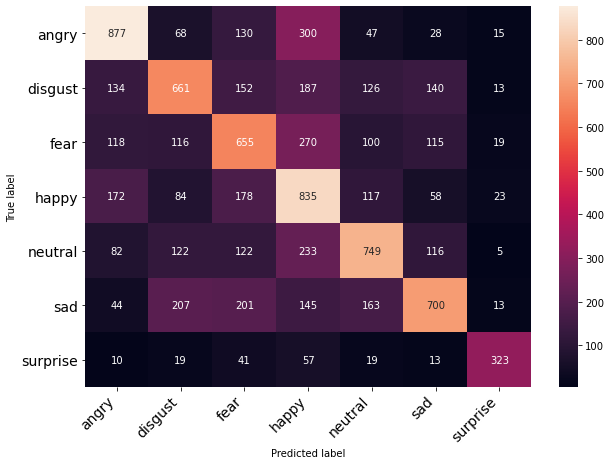

In [38]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [39]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.61      0.60      0.60      1465
     disgust       0.52      0.47      0.49      1413
        fear       0.44      0.47      0.46      1393
       happy       0.41      0.57      0.48      1467
     neutral       0.57      0.52      0.54      1429
         sad       0.60      0.48      0.53      1473
    surprise       0.79      0.67      0.72       482

    accuracy                           0.53      9122
   macro avg       0.56      0.54      0.55      9122
weighted avg       0.54      0.53      0.53      9122

